In [6]:
import numpy as np
import pandas as pd
file_path = "Insampletrainingdata.csv"
df = pd.read_csv ("Insampletrainingdata.csv")
df.head()

,Date,BW1,BW2,ALS1,ALS2,CSI,EPU,STLFSI,VIX,Mkt-RF,...,TERM,DEF,CPI,SMBp,Small Cap Price,Small Cap Return,Small Cap Cumulative Return,Large Cap Price,Large Cap Return,Large Cap Cumulative Return
0,1/03/2004,-0.60,-0.51,-0.53,-0.49,95.8,84.33,-0.45,17.69,-1.32,...,3.32,0.78,187.1,0.0210,50.00,0.020408,0.020408,50.18,0.014762,0.014762
1,1/04/2004,-0.47,-0.34,-0.53,-0.45,94.2,79.73,-0.59,15.70,-1.83,...,3.21,0.73,187.4,-0.0201,50.40,0.008000,0.028571,49.20,-0.016727,-0.002212
2,1/05/2004,-0.48,-0.42,-0.39,-0.20,90.2,97.21,-0.50,17.71,1.17,...,2.98,0.71,188.2,-0.0038,48.03,-0.047024,-0.019796,48.46,-0.015041,-0.017219
3,1/06/2004,-0.41,-0.28,-0.43,-0.24,95.6,85.27,-0.64,15.34,1.86,...,2.71,0.77,188.9,0.0256,49.04,0.021029,0.000816,49.05,0.012175,-0.005254
4,1/07/2004,-0.15,-0.01,-0.50,-0.39,96.7,88.96,-0.56,15.50,-4.06,...,2.67,0.80,189.1,-0.0295,50.89,0.037724,0.038571,49.75,0.020888,0.015524


In [42]:
# Indicator Variables
Indicator_Variable_BW1 =    df[df.columns[1]]
Indicator_Variable_BW2 =    df[df.columns[2]]
Indicator_Variable_ALS1 =   df[df.columns[3]]
Indicator_Variable_ALS2 =   df[df.columns[4]]
Indicator_Variable_Mkt_RF = df[df.columns[9]]
Indicator_Variable_SMB =    df[df.columns[10]]
Indicator_Variable_HML =    df[df.columns[11]]
Indicator_Variable_RF =     df[df.columns[12]]
Indicator_Variable_MOM =    df[df.columns[13]]
smb_data = pd.read_csv('Insampletrainingdata.csv', parse_dates=['Date'], index_col='Date')
print(smb_data.head())

             BW1   BW2  ALS1  ALS2   CSI    EPU  STLFSI    VIX  Mkt-RF   SMB  \
Date                                                                           
2004-01-03 -0.60 -0.51 -0.53 -0.49  95.8  84.33   -0.45  17.69   -1.32  2.10   
2004-01-04 -0.47 -0.34 -0.53 -0.45  94.2  79.73   -0.59  15.70   -1.83 -2.01   
2004-01-05 -0.48 -0.42 -0.39 -0.20  90.2  97.21   -0.50  17.71    1.17 -0.38   
2004-01-06 -0.41 -0.28 -0.43 -0.24  95.6  85.27   -0.64  15.34    1.86  2.56   
2004-01-07 -0.15 -0.01 -0.50 -0.39  96.7  88.96   -0.56  15.50   -4.06 -2.95   

            ...  TERM   DEF    CPI    SMBp  Small Cap Price  Small Cap Return  \
Date        ...                                                                 
2004-01-03  ...  3.32  0.78  187.1  0.0210            50.00          0.020408   
2004-01-04  ...  3.21  0.73  187.4 -0.0201            50.40          0.008000   
2004-01-05  ...  2.98  0.71  188.2 -0.0038            48.03         -0.047024   
2004-01-06  ...  2.71  0.77  188.9

In [43]:
# Drop rows with missing Small Cap Return, Large Cap Return, and EPU values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'EPU'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and EPU columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['EPU'] = smb_data['EPU'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['EPU'].min(), smb_data['EPU'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['EPU'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for EPU is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
small_cap_return = smb_data.loc[best_trade_signals == 1, 'Small Cap Return'].add(1).prod() - 1
large_cap_return = smb_data.loc[best_trade_signals == 0, 'Large Cap Return'].add(1).prod() - 1

# Calculate total portfolio return
total_return = best_portfolio_value / initial_investment - 1

# Calculate the percentage contribution to the total portfolio return
small_cap_contribution_percentage = (small_cap_return / total_return) * 100
large_cap_contribution_percentage = (large_cap_return / total_return) * 100

print(f"Cumulative return attributed to Small Cap: {small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for EPU is: 103.66
The final portfolio value using the best threshold is: $403595.52
The number of switches between Small Cap and Large Cap returns is: 35
The portfolio was invested in Small Cap returns for 105 periods (58.99% of the time).
The portfolio was invested in Large Cap returns for 73 periods (41.01% of the time).
Cumulative return attributed to Small Cap: 0.97
Cumulative return attributed to Large Cap: 1.05
Percentage contribution to total return - Small Cap: 31.93%
Percentage contribution to total return - Large Cap: 34.57%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-10', '2004-01-12', '2005-01-10', '2005-01-11',
               '2007-01-10', '2007-01-11', '2007-01-12', '2008-01-05',
               '2008-01-08', '2008-01-09', '2008-01-10', '2009-01-10',
               '2010-01-01', '2011-01-06', '2011-01-07', '2012-01-04',
               '2012-01-06', '2013-01-08', '2013-01-09', '2013-01-12',
               '2014-01-01', 

In [44]:
# Drop rows with missing Small Cap Return, Large Cap Return, and BW1 values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'BW1'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and BW1 columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['BW1'] = smb_data['BW1'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['BW1'].min(), smb_data['BW1'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['BW1'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for BW1 is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
small_cap_return = smb_data.loc[best_trade_signals == 1, 'Small Cap Return'].add(1).prod() - 1
large_cap_return = smb_data.loc[best_trade_signals == 0, 'Large Cap Return'].add(1).prod() - 1

# Calculate total portfolio return
total_return = best_portfolio_value / initial_investment - 1

# Calculate the percentage contribution to the total portfolio return
small_cap_contribution_percentage = (small_cap_return / total_return) * 100
large_cap_contribution_percentage = (large_cap_return / total_return) * 100

print(f"Cumulative return attributed to Small Cap: {small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for BW1 is: -0.94
The final portfolio value using the best threshold is: $382982.13
The number of switches between Small Cap and Large Cap returns is: 3
The portfolio was invested in Small Cap returns for 176 periods (98.88% of the time).
The portfolio was invested in Large Cap returns for 2 periods (1.12% of the time).
Cumulative return attributed to Small Cap: 2.56
Cumulative return attributed to Large Cap: 0.08
Percentage contribution to total return - Small Cap: 90.44%
Percentage contribution to total return - Large Cap: 2.69%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-04', '2009-01-12', '2010-01-01'], dtype='datetime64[ns]', name='Date', freq=None)
Holding periods for Small Cap returns: DatetimeIndex(['2004-01-04', '2004-01-05', '2004-01-06', '2004-01-07',
               '2004-01-08', '2004-01-09', '2004-01-10', '2004-01-11',
               '2004-01-12', '2005-01-01',
               ...
               '2018-01-03', '2018-01-04

In [45]:
# Drop rows with missing Small Cap Return, Large Cap Return, and BW2 values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'BW2'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and BW2 columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['BW2'] = smb_data['BW2'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['BW2'].min(), smb_data['BW2'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['BW2'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for BW2 is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
small_cap_return = smb_data.loc[best_trade_signals == 1, 'Small Cap Return'].add(1).prod() - 1
large_cap_return = smb_data.loc[best_trade_signals == 0, 'Large Cap Return'].add(1).prod() - 1

# Calculate total portfolio return
total_return = best_portfolio_value / initial_investment - 1

# Calculate the percentage contribution to the total portfolio return
small_cap_contribution_percentage = (small_cap_return / total_return) * 100
large_cap_contribution_percentage = (large_cap_return / total_return) * 100

print(f"Cumulative return attributed to Small Cap: {small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for BW2 is: -0.92
The final portfolio value using the best threshold is: $364973.12
The number of switches between Small Cap and Large Cap returns is: 3
The portfolio was invested in Small Cap returns for 176 periods (98.88% of the time).
The portfolio was invested in Large Cap returns for 2 periods (1.12% of the time).
Cumulative return attributed to Small Cap: 2.39
Cumulative return attributed to Large Cap: 0.08
Percentage contribution to total return - Small Cap: 90.19%
Percentage contribution to total return - Large Cap: 2.89%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-04', '2010-01-04', '2010-01-05'], dtype='datetime64[ns]', name='Date', freq=None)
Holding periods for Small Cap returns: DatetimeIndex(['2004-01-04', '2004-01-05', '2004-01-06', '2004-01-07',
               '2004-01-08', '2004-01-09', '2004-01-10', '2004-01-11',
               '2004-01-12', '2005-01-01',
               ...
               '2018-01-03', '2018-01-04

In [46]:
# Drop rows with missing Small Cap Return, Large Cap Return, and ALS1 values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'ALS1'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and ALS1 columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['ALS1'] = smb_data['ALS1'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['ALS1'].min(), smb_data['ALS1'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['ALS1'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for ALS1 is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
small_cap_return = smb_data.loc[best_trade_signals == 1, 'Small Cap Return'].add(1).prod() - 1
large_cap_return = smb_data.loc[best_trade_signals == 0, 'Large Cap Return'].add(1).prod() - 1

# Calculate total portfolio return
total_return = best_portfolio_value / initial_investment - 1

# Calculate the percentage contribution to the total portfolio return
small_cap_contribution_percentage = (small_cap_return / total_return) * 100
large_cap_contribution_percentage = (large_cap_return / total_return) * 100

print(f"Cumulative return attributed to Small Cap: {small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for ALS1 is: -0.38
The final portfolio value using the best threshold is: $458891.87
The number of switches between Small Cap and Large Cap returns is: 16
The portfolio was invested in Small Cap returns for 80 periods (44.94% of the time).
The portfolio was invested in Large Cap returns for 98 periods (55.06% of the time).
Cumulative return attributed to Small Cap: 1.11
Cumulative return attributed to Large Cap: 1.18
Percentage contribution to total return - Small Cap: 30.87%
Percentage contribution to total return - Large Cap: 32.79%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2008-01-03', '2009-01-11', '2010-01-01', '2011-01-01',
               '2012-01-01', '2012-01-04', '2012-01-10', '2015-01-08',
               '2015-01-09', '2015-01-10', '2016-01-02', '2016-01-09',
               '2016-01-10', '2016-01-12', '2017-01-01', '2017-01-02'],
              dtype='datetime64[ns]', name='Date', freq=None)
Holding periods for Small Cap returns:

In [59]:
# Drop rows with missing Small Cap Return, Large Cap Return, and ALS2 values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'ALS2'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and ALS2 columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['ALS2'] = smb_data['ALS2'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['ALS2'].min(), smb_data['ALS2'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['ALS2'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for ALS2 is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for ALS2 is: -0.32
The final portfolio value using the best threshold is: $409180.37
The number of switches between Small Cap and Large Cap returns is: 12
The portfolio was invested in Small Cap returns for 81 periods (45.51% of the time).
The portfolio was invested in Large Cap returns for 97 periods (54.49% of the time).
Cumulative return attributed to Small Cap: 1.20
Cumulative return attributed to Large Cap: 0.86
Percentage contribution to total return - Small Cap: 53.72%
Percentage contribution to total return - Large Cap: 46.28%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-06', '2004-01-08', '2008-01-08', '2011-01-01',
               '2011-01-03', '2012-01-05', '2012-01-10', '2015-01-02',
               '2015-01-03', '2015-01-05', '2015-01-12', '2016-01-06'],
              dtype='datetime64[ns]', name='Date', freq=None)
Holding periods for Small Cap returns: DatetimeIndex(['2004-01-06', '2004-01-07', '2008-01-08', '2008-01-09',

In [60]:
# Drop rows with missing Small Cap Return, Large Cap Return, and BW1 values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'BW1'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and BW1 columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['BW1'] = smb_data['BW1'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['BW1'].min(), smb_data['BW1'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['BW1'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for BW1 is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for BW1 is: -0.94
The final portfolio value using the best threshold is: $382982.13
The number of switches between Small Cap and Large Cap returns is: 3
The portfolio was invested in Small Cap returns for 176 periods (98.88% of the time).
The portfolio was invested in Large Cap returns for 2 periods (1.12% of the time).
Cumulative return attributed to Small Cap: 2.56
Cumulative return attributed to Large Cap: 0.08
Percentage contribution to total return - Small Cap: 99.97%
Percentage contribution to total return - Large Cap: 0.03%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-04', '2009-01-12', '2010-01-01'], dtype='datetime64[ns]', name='Date', freq=None)
Holding periods for Small Cap returns: DatetimeIndex(['2004-01-04', '2004-01-05', '2004-01-06', '2004-01-07',
               '2004-01-08', '2004-01-09', '2004-01-10', '2004-01-11',
               '2004-01-12', '2005-01-01',
               ...
               '2018-01-03', '2018-01-04

In [62]:
# Drop rows with missing Small Cap Return, Large Cap Return, and EPU values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'EPU'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and EPU columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['EPU'] = smb_data['EPU'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['EPU'].min(), smb_data['EPU'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['EPU'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for EPU is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for EPU is: 103.66
The final portfolio value using the best threshold is: $403595.52
The number of switches between Small Cap and Large Cap returns is: 35
The portfolio was invested in Small Cap returns for 105 periods (58.99% of the time).
The portfolio was invested in Large Cap returns for 73 periods (41.01% of the time).
Cumulative return attributed to Small Cap: 0.97
Cumulative return attributed to Large Cap: 1.05
Percentage contribution to total return - Small Cap: 57.06%
Percentage contribution to total return - Large Cap: 42.94%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-10', '2004-01-12', '2005-01-10', '2005-01-11',
               '2007-01-10', '2007-01-11', '2007-01-12', '2008-01-05',
               '2008-01-08', '2008-01-09', '2008-01-10', '2009-01-10',
               '2010-01-01', '2011-01-06', '2011-01-07', '2012-01-04',
               '2012-01-06', '2013-01-08', '2013-01-09', '2013-01-12',
               '2014-01-01', 

In [50]:
# Drop rows with missing Small Cap Return, Large Cap Return, and ALS1 values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'ALS1'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and ALS1 columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['ALS1'] = smb_data['ALS1'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['ALS1'].min(), smb_data['ALS1'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['ALS1'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for ALS1 is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for ALS1 is: -0.38
The final portfolio value using the best threshold is: $458891.87
The number of switches between Small Cap and Large Cap returns is: 16
The portfolio was invested in Small Cap returns for 80 periods (44.94% of the time).
The portfolio was invested in Large Cap returns for 98 periods (55.06% of the time).
Cumulative return attributed to Small Cap: 1.11
Cumulative return attributed to Large Cap: 1.18
Percentage contribution to total return - Small Cap: 43.46%
Percentage contribution to total return - Large Cap: 56.54%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2008-01-03', '2009-01-11', '2010-01-01', '2011-01-01',
               '2012-01-01', '2012-01-04', '2012-01-10', '2015-01-08',
               '2015-01-09', '2015-01-10', '2016-01-02', '2016-01-09',
               '2016-01-10', '2016-01-12', '2017-01-01', '2017-01-02'],
              dtype='datetime64[ns]', name='Date', freq=None)
Holding periods for Small Cap returns:

In [51]:
# Drop rows with missing Small Cap Return, Large Cap Return, and CSI values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'CSI'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and CSI columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['CSI'] = smb_data['CSI'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['CSI'].min(), smb_data['CSI'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['CSI'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for CSI is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for CSI is: 59.55
The final portfolio value using the best threshold is: $449631.29
The number of switches between Small Cap and Large Cap returns is: 9
The portfolio was invested in Small Cap returns for 170 periods (95.51% of the time).
The portfolio was invested in Large Cap returns for 8 periods (4.49% of the time).
Cumulative return attributed to Small Cap: 6.45
Cumulative return attributed to Large Cap: -0.40
Percentage contribution to total return - Small Cap: 100.29%
Percentage contribution to total return - Large Cap: -0.29%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-04', '2008-01-07', '2008-01-08', '2008-01-11',
               '2009-01-01', '2009-01-03', '2009-01-05', '2011-01-09',
               '2011-01-11'],
              dtype='datetime64[ns]', name='Date', freq=None)
Holding periods for Small Cap returns: DatetimeIndex(['2004-01-04', '2004-01-05', '2004-01-06', '2004-01-07',
               '2004-01-08', '2004-01-09',

In [52]:
# Drop rows with missing Small Cap Return, Large Cap Return, and STLFSI values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'STLFSI'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and STLFSI columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['STLFSI'] = smb_data['STLFSI'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['STLFSI'].min(), smb_data['STLFSI'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['STLFSI'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for STLFSI is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for STLFSI is: -0.46
The final portfolio value using the best threshold is: $423080.65
The number of switches between Small Cap and Large Cap returns is: 19
The portfolio was invested in Small Cap returns for 102 periods (57.30% of the time).
The portfolio was invested in Large Cap returns for 76 periods (42.70% of the time).
Cumulative return attributed to Small Cap: 0.62
Cumulative return attributed to Large Cap: 1.61
Percentage contribution to total return - Small Cap: 34.09%
Percentage contribution to total return - Large Cap: 65.91%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-04', '2004-01-05', '2007-01-09', '2010-01-04',
               '2010-01-05', '2011-01-05', '2011-01-06', '2012-01-11',
               '2012-01-12', '2013-01-01', '2013-01-07', '2013-01-11',
               '2014-01-11', '2014-01-12', '2015-01-01', '2017-01-06',
               '2018-01-03', '2018-01-08', '2018-01-12'],
              dtype='datetime64[ns]', na

In [53]:
# Drop rows with missing Small Cap Return, Large Cap Return, and VIX values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'VIX'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and VIX columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['VIX'] = smb_data['VIX'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['VIX'].min(), smb_data['VIX'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['VIX'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for VIX is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for VIX is: 13.50
The final portfolio value using the best threshold is: $387462.09
The number of switches between Small Cap and Large Cap returns is: 29
The portfolio was invested in Small Cap returns for 124 periods (69.66% of the time).
The portfolio was invested in Large Cap returns for 54 periods (30.34% of the time).
Cumulative return attributed to Small Cap: 0.54
Cumulative return attributed to Large Cap: 1.52
Percentage contribution to total return - Small Cap: 44.66%
Percentage contribution to total return - Large Cap: 55.34%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-04', '2005-01-01', '2005-01-05', '2005-01-07',
               '2005-01-11', '2005-01-12', '2006-01-06', '2006-01-09',
               '2007-01-04', '2007-01-05', '2007-01-07', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-12',
               '2014-01-01', '2014-01-06', '2014-01-11', '2014-01-12',
               '2015-01-01', '

In [54]:
# Drop rows with missing Small Cap Return, Large Cap Return, and SMB values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'SMB'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and SMB columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['SMB'] = smb_data['SMB'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['SMB'].min(), smb_data['SMB'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['SMB'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for SMB is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for SMB is: -0.05
The final portfolio value using the best threshold is: $1309619.92
The number of switches between Small Cap and Large Cap returns is: 100
The portfolio was invested in Small Cap returns for 92 periods (51.69% of the time).
The portfolio was invested in Large Cap returns for 86 periods (48.31% of the time).
Cumulative return attributed to Small Cap: 16.56
Cumulative return attributed to Large Cap: -0.25
Percentage contribution to total return - Small Cap: 101.46%
Percentage contribution to total return - Large Cap: -1.46%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-04', '2004-01-05', '2004-01-07', '2004-01-08',
               '2004-01-10', '2005-01-01', '2005-01-06', '2005-01-09',
               '2005-01-12', '2006-01-01', '2006-01-02', '2006-01-03',
               '2006-01-04', '2006-01-05', '2006-01-09', '2006-01-10',
               '2006-01-11', '2007-01-01', '2007-01-02', '2007-01-05',
               '2007-01-06

In [55]:
# Drop rows with missing Small Cap Return, Large Cap Return, and HML values
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'HML'], inplace=True)

# Fill NaN values in Small Cap Return, Large Cap Return, and HML columns with forward fill method
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['HML'] = smb_data['HML'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['HML'].min(), smb_data['HML'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['HML'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for HML is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for HML is: -1.30
The final portfolio value using the best threshold is: $588433.41
The number of switches between Small Cap and Large Cap returns is: 51
The portfolio was invested in Small Cap returns for 130 periods (73.03% of the time).
The portfolio was invested in Large Cap returns for 48 periods (26.97% of the time).
Cumulative return attributed to Small Cap: 7.70
Cumulative return attributed to Large Cap: -0.32
Percentage contribution to total return - Small Cap: 101.58%
Percentage contribution to total return - Large Cap: -1.58%
Switch points between Small Cap and Large Cap returns: DatetimeIndex(['2004-01-04', '2004-01-05', '2004-01-06', '2006-01-09',
               '2006-01-10', '2007-01-05', '2007-01-06', '2007-01-08',
               '2007-01-12', '2008-01-06', '2008-01-08', '2008-01-11',
               '2009-01-01', '2009-01-02', '2009-01-04', '2009-01-07',
               '2009-01-08', '2009-01-11', '2009-01-12', '2010-01-06',
               '2010-01-08',

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the in-sample data
smb_data = pd.read_csv("Insampletrainingdata.csv")
smb_data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'Twitter'], inplace=True)
smb_data['Small Cap Return'] = smb_data['Small Cap Return'].ffill()
smb_data['Large Cap Return'] = smb_data['Large Cap Return'].ffill()
smb_data['Twitter'] = smb_data['Twitter'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(smb_data['Twitter'].min(), smb_data['Twitter'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the current threshold
    smb_data['Trade Signal'] = smb_data['Twitter'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    smb_data['Selected Return'] = smb_data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    smb_data['Strategy Return'] = smb_data['Selected Return']
    
    # Calculate the portfolio value over time
    smb_data['Portfolio Value'] = initial_investment * (1 + smb_data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = smb_data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = smb_data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for Twitter is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (smb_data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (smb_data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = smb_data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = smb_data.index[best_trade_signals == 1]
large_cap_holding_periods = smb_data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for Twitter is: 145.21
The final portfolio value using the best threshold is: $241916.37
The number of switches between Small Cap and Large Cap returns is: 10
The portfolio was invested in Small Cap returns for 5 periods (5.56% of the time).
The portfolio was invested in Large Cap returns for 85 periods (94.44% of the time).
Cumulative return attributed to Small Cap: 0.09
Cumulative return attributed to Large Cap: 1.21
Percentage contribution to total return - Small Cap: 0.45%
Percentage contribution to total return - Large Cap: 99.55%
Switch points between Small Cap and Large Cap returns: Index([95, 96, 143, 144, 149, 150, 172, 173, 174, 175], dtype='int64')
Holding periods for Small Cap returns: Index([95, 143, 149, 172, 174], dtype='int64')
Holding periods for Large Cap returns: Index([ 88,  89,  90,  91,  92,  93,  94,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 12

The final portfolio value using the VIX trading rule is: $387462.09
The overall return using the VIX trading rule is: 287.46%


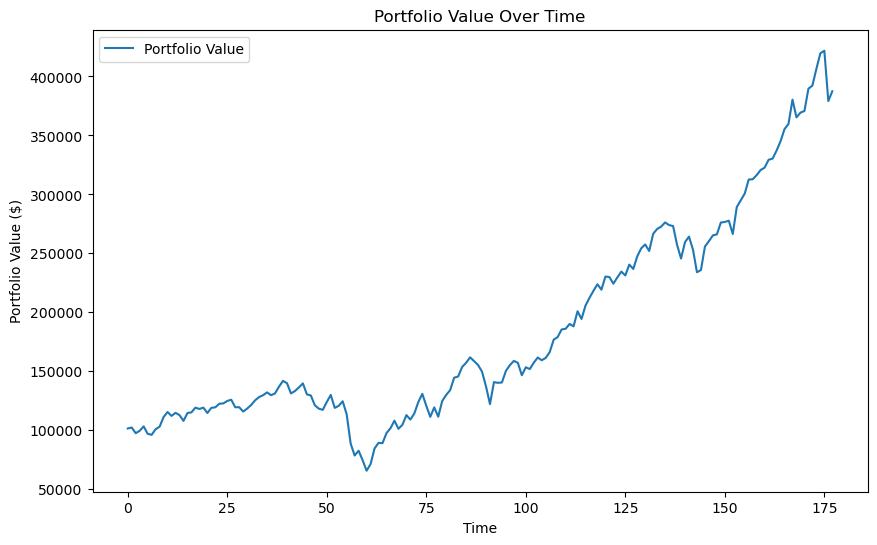

The number of switches between Small Cap and Large Cap returns is: 29
The portfolio was invested in Small Cap returns for 124 periods (69.66% of the time).
The portfolio was invested in Large Cap returns for 54 periods (30.34% of the time).
Cumulative return attributed to Small Cap: 0.54
Cumulative return attributed to Large Cap: 1.52
Percentage contribution to total return - Small Cap: 44.66%
Percentage contribution to total return - Large Cap: 55.34%


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the historical data
data = pd.read_csv("Insampletrainingdata.csv")
data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'VIX'], inplace=True)
data['Small Cap Return'] = data['Small Cap Return'].ffill()
data['Large Cap Return'] = data['Large Cap Return'].ffill()
data['VIX'] = data['VIX'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Define the VIX threshold
vix_threshold = 13.5

# Generate trade signals based on the VIX threshold
data['Trade Signal'] = data['VIX'].shift(1).apply(lambda x: 1 if x > vix_threshold else 0)

# Select returns based on the trade signal
data['Selected Return'] = data.apply(
    lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)

# Calculate the strategy returns
data['Strategy Return'] = data['Selected Return']

# Calculate the portfolio value over time
data['Portfolio Value'] = initial_investment * (1 + data['Strategy Return']).cumprod()

# Get the final portfolio value
final_portfolio_value = data['Portfolio Value'].iloc[-1]

# Print the final portfolio value
print(f"The final portfolio value using the VIX trading rule is: ${final_portfolio_value:.2f}")

# Optionally, calculate the overall return
overall_return = (final_portfolio_value / initial_investment) - 1
print(f"The overall return using the VIX trading rule is: {overall_return:.2%}")

# Optionally, visualize the portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(data['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Additional analysis: Number of switches and average composition of the portfolio
num_switches = (data['Trade Signal'].diff().abs() == 1).sum()
num_small_cap = (data['Trade Signal'] == 1).sum()
num_large_cap = (data['Trade Signal'] == 0).sum()
total_periods = len(data['Trade Signal'])

print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")
print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (data.loc[data['Trade Signal'] == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (data.loc[data['Trade Signal'] == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the historical data
data = pd.read_csv("Insampletrainingdata.csv")
data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'VIX'], inplace=True)
data['Small Cap Return'] = data['Small Cap Return'].ffill()
data['Large Cap Return'] = data['Large Cap Return'].ffill()
data['VIX'] = data['VIX'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(data['VIX'].min(), data['VIX'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the previous period's VIX value
    data['Trade Signal'] = data['VIX'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    data['Selected Return'] = data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    data['Strategy Return'] = data['Selected Return']
    
    # Calculate the portfolio value over time
    data['Portfolio Value'] = initial_investment * (1 + data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for VIX is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = data.index[best_trade_signals == 1]
large_cap_holding_periods = data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for VIX is: 13.50
The final portfolio value using the best threshold is: $387462.09
The number of switches between Small Cap and Large Cap returns is: 29
The portfolio was invested in Small Cap returns for 124 periods (69.66% of the time).
The portfolio was invested in Large Cap returns for 54 periods (30.34% of the time).
Cumulative return attributed to Small Cap: 0.54
Cumulative return attributed to Large Cap: 1.52
Percentage contribution to total return - Small Cap: 44.66%
Percentage contribution to total return - Large Cap: 55.34%
Switch points between Small Cap and Large Cap returns: Index([  1,  10,  14,  16,  20,  21,  27,  30,  37,  38,  40, 109, 110, 111,
       112, 117, 118, 123, 128, 129, 130, 134, 136, 149, 151, 154, 168, 173,
       176],
      dtype='int64')
Holding periods for Small Cap returns: Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  14,
       ...
       151, 152, 153, 168, 169, 170, 171, 172, 176, 177],
      dtype='int64', length=124)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the historical data
data = pd.read_csv("Insampletrainingdata.csv")
data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'VIX'], inplace=True)
data['Small Cap Return'] = data['Small Cap Return'].ffill()
data['Large Cap Return'] = data['Large Cap Return'].ffill()
data['VIX'] = data['VIX'].ffill()

# Define the initial portfolio value
initial_investment = 100000  # $100,000

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf
best_trade_signals = None

# Define a wider range of thresholds to test
thresholds = np.linspace(data['VIX'].min(), data['VIX'].max(), 500)

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the previous period's VIX value
    data['Trade Signal'] = data['VIX'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    data['Selected Return'] = data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    data['Strategy Return'] = data['Selected Return']
    
    # Calculate the portfolio value over time
    data['Portfolio Value'] = initial_investment * (1 + data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value
        best_trade_signals = data['Trade Signal'].copy()

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for VIX is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (best_trade_signals.diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (best_trade_signals == 1).sum()
num_large_cap = (best_trade_signals == 0).sum()
total_periods = len(best_trade_signals)

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (data.loc[best_trade_signals == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (data.loc[best_trade_signals == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = data.index[best_trade_signals.diff().abs() == 1]
small_cap_holding_periods = data.index[best_trade_signals == 1]
large_cap_holding_periods = data.index[best_trade_signals == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")


The best threshold for VIX is: 13.50
The final portfolio value using the best threshold is: $387462.09
The number of switches between Small Cap and Large Cap returns is: 29
The portfolio was invested in Small Cap returns for 124 periods (69.66% of the time).
The portfolio was invested in Large Cap returns for 54 periods (30.34% of the time).
Cumulative return attributed to Small Cap: 0.54
Cumulative return attributed to Large Cap: 1.52
Percentage contribution to total return - Small Cap: 44.66%
Percentage contribution to total return - Large Cap: 55.34%
Switch points between Small Cap and Large Cap returns: Index([  1,  10,  14,  16,  20,  21,  27,  30,  37,  38,  40, 109, 110, 111,
       112, 117, 118, 123, 128, 129, 130, 134, 136, 149, 151, 154, 168, 173,
       176],
      dtype='int64')
Holding periods for Small Cap returns: Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  14,
       ...
       151, 152, 153, 168, 169, 170, 171, 172, 176, 177],
      dtype='int64', length=124)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("Insampletrainingdata.csv")
data.dropna(subset=['Small Cap Return', 'Large Cap Return', 'VIX'], inplace=True)
data['Small Cap Return'] = data['Small Cap Return'].ffill()
data['Large Cap Return'] = data['Large Cap Return'].ffill()
data['VIX'] = data['VIX'].ffill()

# Define initial portfolio value
initial_investment = 100000  # $100,000

# Define the range of thresholds to test
thresholds = np.linspace(data['VIX'].min(), data['VIX'].max(), 500)

# Initialize variables to store the best threshold and corresponding portfolio value
best_threshold = None
best_portfolio_value = -np.inf

# Perform grid search to find the optimal threshold
for threshold in thresholds:
    # Generate trade signals based on the previous period's VIX value
    data['Trade Signal'] = data['VIX'].shift(1).apply(lambda x: 1 if x > threshold else 0)
    
    # Select returns based on the trade signal
    data['Selected Return'] = data.apply(
        lambda row: row['Small Cap Return'] if row['Trade Signal'] == 1 else row['Large Cap Return'], axis=1)
    
    # Calculate the strategy returns
    data['Strategy Return'] = data['Selected Return']
    
    # Calculate the portfolio value over time
    data['Portfolio Value'] = initial_investment * (1 + data['Strategy Return']).cumprod()
    
    # Get the final portfolio value
    final_portfolio_value = data['Portfolio Value'].iloc[-1]
    
    # Update the best threshold and portfolio value if the current one is better
    if final_portfolio_value > best_portfolio_value:
        best_threshold = threshold
        best_portfolio_value = final_portfolio_value

# Print the best threshold and the corresponding portfolio value
print(f"The best threshold for VIX is: {best_threshold:.2f}")
print(f"The final portfolio value using the best threshold is: ${best_portfolio_value:.2f}")

# Calculate the number of switches between Small Cap and Large Cap returns
num_switches = (data['Trade Signal'].diff().abs() == 1).sum()
print(f"The number of switches between Small Cap and Large Cap returns is: {num_switches}")

# Calculate the average composition of the portfolio
num_small_cap = (data['Trade Signal'] == 1).sum()
num_large_cap = (data['Trade Signal'] == 0).sum()
total_periods = len(data['Trade Signal'])

print(f"The portfolio was invested in Small Cap returns for {num_small_cap} periods ({num_small_cap / total_periods:.2%} of the time).")
print(f"The portfolio was invested in Large Cap returns for {num_large_cap} periods ({num_large_cap / total_periods:.2%} of the time).")

# Calculate cumulative returns attributed to Small Cap and Large Cap
cumulative_small_cap_return = (data.loc[data['Trade Signal'] == 1, 'Small Cap Return'] + 1).prod() - 1
cumulative_large_cap_return = (data.loc[data['Trade Signal'] == 0, 'Large Cap Return'] + 1).prod() - 1

# Calculate the total portfolio return
total_return = final_portfolio_value / initial_investment - 1

# Calculate the weighted contributions
weighted_small_cap_return = (cumulative_small_cap_return * (num_small_cap / total_periods))
weighted_large_cap_return = (cumulative_large_cap_return * (num_large_cap / total_periods))

# Normalize contributions to add up to 100%
total_contributions = weighted_small_cap_return + weighted_large_cap_return
small_cap_contribution_percentage = (weighted_small_cap_return / total_contributions) * 100
large_cap_contribution_percentage = (weighted_large_cap_return / total_contributions) * 100

print(f"Cumulative return attributed to Small Cap: {cumulative_small_cap_return:.2f}")
print(f"Cumulative return attributed to Large Cap: {cumulative_large_cap_return:.2f}")
print(f"Percentage contribution to total return - Small Cap: {small_cap_contribution_percentage:.2f}%")
print(f"Percentage contribution to total return - Large Cap: {large_cap_contribution_percentage:.2f}%")

# Identify switch points and holding periods
switch_points = data.index[data['Trade Signal'].diff().abs() == 1]
small_cap_holding_periods = data.index[data['Trade Signal'] == 1]
large_cap_holding_periods = data.index[data['Trade Signal'] == 0]

print(f"Switch points between Small Cap and Large Cap returns: {switch_points}")
print(f"Holding periods for Small Cap returns: {small_cap_holding_periods}")
print(f"Holding periods for Large Cap returns: {large_cap_holding_periods}")

# Export the relevant data to a CSV file for use in Excel
data[['VIX', 'Trade Signal', 'Small Cap Return', 'Large Cap Return', 'Selected Return', 'Strategy Return', 'Portfolio Value']].to_csv("optimized_trading_strategy_VIX.csv", index=False)

print("Optimized trading strategy data has been exported to 'optimized_trading_strategy_VIX.csv'.")


The best threshold for VIX is: 13.50
The final portfolio value using the best threshold is: $387462.09
The number of switches between Small Cap and Large Cap returns is: 0
The portfolio was invested in Small Cap returns for 0 periods (0.00% of the time).
The portfolio was invested in Large Cap returns for 178 periods (100.00% of the time).
Cumulative return attributed to Small Cap: 0.00
Cumulative return attributed to Large Cap: 2.41
Percentage contribution to total return - Small Cap: 0.00%
Percentage contribution to total return - Large Cap: 100.00%
Switch points between Small Cap and Large Cap returns: Index([], dtype='int64')
Holding periods for Small Cap returns: Index([], dtype='int64')
Holding periods for Large Cap returns: Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177],
      dtype='int64', length=178)
Optimized trading strategy data has been exported to 'optimized_trading_strategy_VIX.csv'.
